In [88]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import operator
from math import floor,ceil
import tensorflow as tf
print(tf.__version__)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pytesseract
import time

2.1.0


In [34]:
def proc_img(img):
    img1 = cv.GaussianBlur(img.copy(), (9, 9), 0)
    img1 = cv.adaptiveThreshold(img1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    img1 = cv.bitwise_not(img1, img1)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    img1 = cv.dilate(img1, kernel)
    return img1

In [35]:
def show_img(img):
	cv.imshow('image', img)
	cv.waitKey(0)
	cv.destroyAllWindows()

In [36]:
def display_points(img, points, radius=5, colour=(0, 0, 255)):
    img = img.copy()
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    for point in points:
        img = cv.circle(img, tuple(int(x) for x in point), radius, colour, -1)

In [37]:
def grid(img):
    contours, _ = cv.findContours(img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    cnt = contours[0]
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    return [cnt[top_left][0], cnt[top_right][0], cnt[bottom_right][0], cnt[bottom_left][0]]

In [110]:
def perspect(img,corners):
    rows,cols = img.shape
    h = corners[1][0] - corners[0][0]
    w = corners[2][1] - corners[1][1]
    pts1 = np.float32([corners[0],corners[1],corners[3],corners[2]])
    #pts1 = np.float32([[x,y],[x+w,y],[x,y+h],[x+w,y+h]])
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    M = cv.getPerspectiveTransform(pts1,pts2)
    dst = cv.warpPerspective(img,M,(h,w))
    #plt.subplot(121),plt.imshow(img,'gray'),plt.title('Input')
    #plt.subplot(122),plt.imshow(dst,'gray'),plt.title('Output')
    return dst

In [39]:
def extract_grid(img):
    row, col = img.shape
    rowp = row/9
    colp = col/9
    imgp = []
    dim = (floor(rowp),floor(colp))
    for j in range(9):
        for i in range(9):
            pts1 = np.float32([[i*1.025*rowp,j*1.025*colp],[(i+1)*0.975*rowp,j*1.025*colp],[i*1.025*rowp,(j+1)*0.975*colp],[(i+1)*0.975*rowp,(j+1)*0.975*colp]])
            pts2 = np.float32([[0,0],[rowp,0],[0,colp],[rowp,colp]])
            M = cv.getPerspectiveTransform(pts1,pts2)
            dst = cv.warpPerspective(img,M,dim)
            imgp.append(dst)
    return imgp

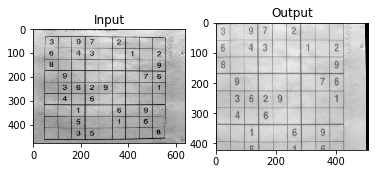

In [107]:
img = cv.imread('./sudoku_images_2/image9.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)
imgp = extract_grid(img_final)

In [92]:
file = open('./sudoku_images/sudoku1.sud', 'r')  
l = []
for each in file: 
    a = each.split()
    for k in a:
        if(k.isnumeric()):
            l.append(k)
print(l[5])
print(len(l))

5
81


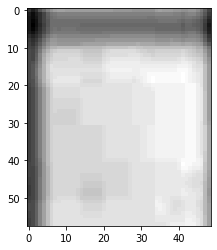

In [83]:
plt.imshow(imgp[9],'gray')

In [111]:
def complete(path):
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    processed = proc_img(img)
    corners = grid(processed)
    img_final = perspect(img,corners)
    imgp = extract_grid(img_final)
    return imgp

In [71]:
def extract_data_1():
    imlist = [os.path.join('./sudoku_images',f) for f in os.listdir('./sudoku_images') if f.endswith('.jpg')]
    label = (imlist[0][:-4]+".sud")
    file = open('./sudoku_images_2/image1.dat', 'r')  
    l = []
    for each in file: 
        a = each.split()
        for k in a:
            if(k.isnumeric()):
                l.append(k)
    print(l)
    print(len(l))

In [112]:
def extract_data_1(count):
    imlist = [os.path.join('./sudoku_images',f) for f in os.listdir('./sudoku_images') if f.endswith('.jpg')]
    for imname in imlist:
        sud = (imname[:-4]+".sud")
        file = open(sud, 'r')  
        label = []
        for each in file: 
            a = each.split()
            for k in a:
                if(k.isnumeric()):
                    label.append(k)
        imgp = complete(imname)
        for i in range(80):
            #print(label[i])
            #plt.imshow(imgp[i])
            #time.sleep(2)
            cv.imwrite('./ocr_data/Sample_' + label[i]+'/'+str(count)+'.jpg' ,imgp[i])
            count = count+ 1
    return count

In [113]:
count = extract_data_1(0)

In [97]:
def extract_data_2():
    imlist = [os.path.join('./sudoku_images_2',f) for f in os.listdir('./sudoku_images_2') if f.endswith('.jpg')]
    count = 0
    for imname in imlist:
        sud = (imname[:-4]+".dat")
        file = open(sud, 'r')  
        label = []
        for each in file: 
            a = each.split()
            for k in a:
                if(k.isnumeric()):
                    label.append(k)
        imgp = complete(imname)
        for i in range(80):
            #print(label[i])
            #plt.imshow(imgp[i])
            #time.sleep(2)
            cv.imwrite('./ocr_data/Sample_' + label[i]+'/'+str(count)+'.jpg' ,imgp[i])
            count = count+ 1

In [98]:
extract_data_2()

In [114]:
print(count)

4240
